# Using `SimilaritySearch` and `ManifoldLearning` 

This example shows how to use `SimilaritySearch` with the `ManifoldLearning` package through the `SimSearchManifoldLearning` package.

We will reproduce two small examples, please check the documentation of the respective packages to get access to more keywords and features.

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

_june 2nd, 2023: working with `SimilaritySearch` v0.10. I also moved from `Plots` to `Makie`._

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/SimilaritySearchDemos/primes`


In [2]:
# Pkg.update()

In [3]:
if !isfile("Manifest.toml")
    Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.10"),
        PackageSpec(name="SimSearchManifoldLearning", version="0.2.9"),
        PackageSpec(name="ManifoldLearning"),
        PackageSpec(name="CairoMakie"),
        PackageSpec(name="ColorSchemes"),
        PackageSpec(name="Colors"),
        PackageSpec(name="Primes"),
        PackageSpec(name="StatsBase"),
        PackageSpec(name="HypertextLiteral"),
    ])
end

using SimilaritySearch, SimSearchManifoldLearning, ManifoldLearning
using CairoMakie, ColorSchemes, Colors, Markdown
using Primes, StatsBase, LinearAlgebra, HypertextLiteral

Now, we can define our dataset. The set of factors are found using the `Primes` package. Note that we use `VectorDatabase` to represent the dataset.

## Parameters to generate the dataset

Please feel free to play with all parameters and look at what happens with the visualization

In [4]:
n = 100_000
F = Vector{Vector{Int32}}(undef, n)

for i in 2:n+1
    s = Int32[convert(Int32, f) for f in factor(Set, i)]
    sort!(s)
    F[i-1] = s
end

db = VectorDatabase(F)

VectorDatabase{Vector{Vector{Int32}}}(Vector{Int32}[[2], [3], [2], [5], [2, 3], [7], [2], [3], [2, 5], [11]  …  [2, 29, 431], [3, 33331], [2, 17, 173], [5, 7, 2857], [2, 3, 13, 641], [19, 277], [2, 49999], [3, 41, 271], [2, 5], [11, 9091]])

We use Int32 ordered arrays to store prime factors to represent each integer. In the following cell define the cosine distance equivalent for this representation. While other representations may perform faster, this is quite straighforward and demonstrates the use of user's defined distance functions.

# Reproducing the `ManifoldLearning` documentation example

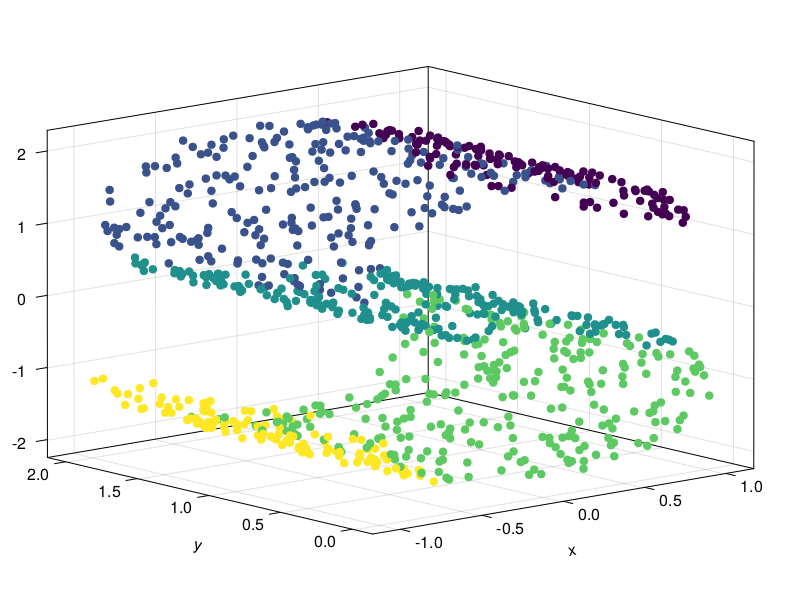

In [5]:
X, L = ManifoldLearning.scurve(segments=5)
let fig = Figure()
    ax = Axis3(fig[1, 1], elevation=0.2)
    scatter!(ax, X[1, :], X[2, :], X[3, :], color=L)
    # hidedecorations!(ax)
    fig
end

`SimilaritySearch` support exact and approximate algorithms to solve `k` nearest neighbors. Also, it supports different metrics. For instance, let see how the selection of the distance function modifies the projection.

## Manhattan distance ($L_1$)


  0.168583 seconds (206.14 k allocations: 13.298 MiB, 99.74% compilation time)


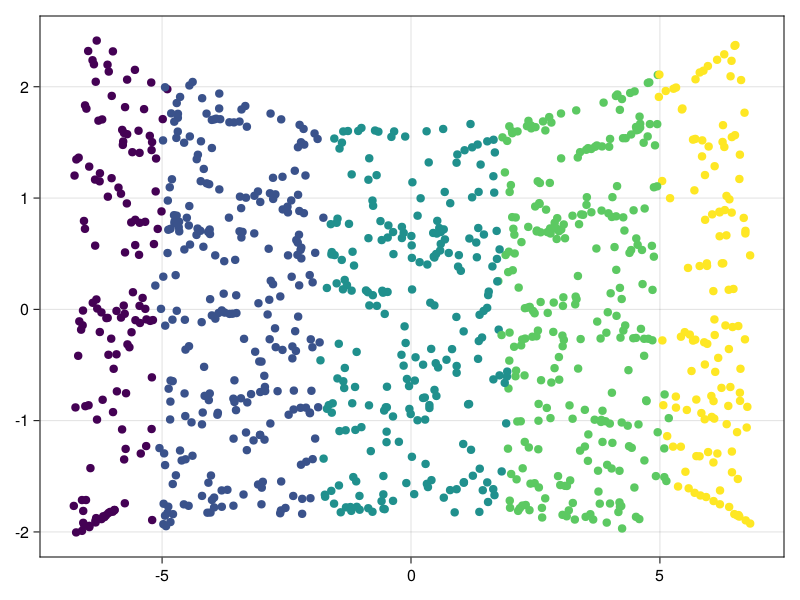

In [6]:
display(md"""
`SimilaritySearch` support exact and approximate algorithms to solve `k` nearest neighbors. Also, it supports different metrics. For instance, let see how the selection of the distance function modifies the projection.

## Manhattan distance ($L_1$)
""")

let	Y = predict(fit(Isomap, X, nntype=ApproxManhattan))
	scatter(Y[1,:], Y[2,:], color=L)
end

## Euclidean distance ($L_2$)


  0.145958 seconds (195.83 k allocations: 12.605 MiB, 99.64% compilation time)


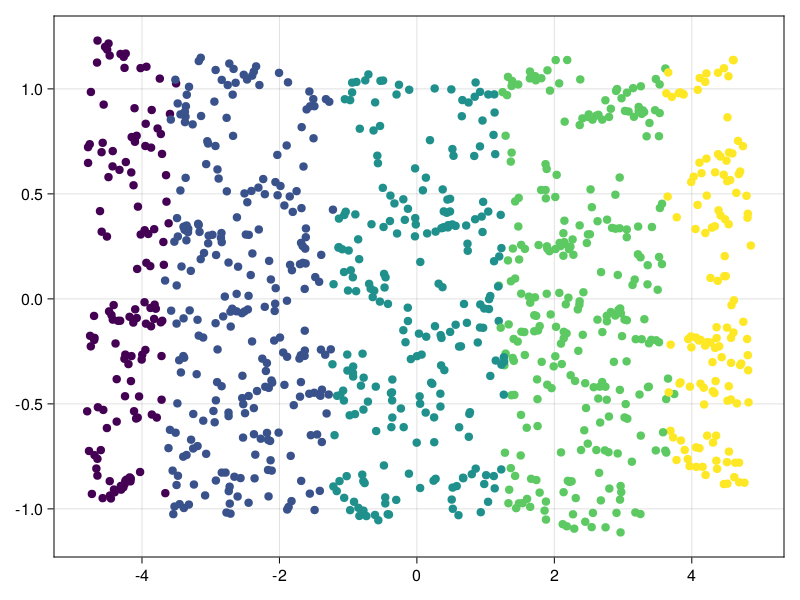

In [7]:
display(md"""## Euclidean distance ($L_2$)""")

let
    E = predict(fit(Isomap, X, nntype=ApproxEuclidean))
	# Y = predict(fit(Isomap, X))
	scatter(E[1,:], E[2,:], color=L)
end

## Chebyshev distance ($L_\infty$)


  0.180057 seconds (195.83 k allocations: 12.609 MiB, 15.23% gc time, 99.71% compilation time)


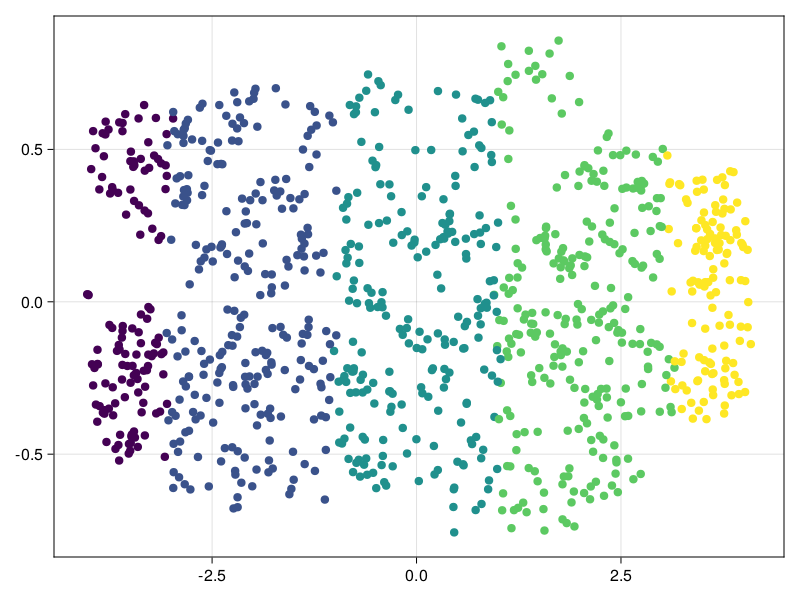

In [8]:
display(md"""## Chebyshev distance ($L_\infty$)""")
let
	Ch = predict(fit(Isomap, X, nntype=ApproxChebyshev))
	# Y = predict(fit(Isomap, X))
	scatter(Ch[1,:], Ch[2,:], color=L)
end


# Visualizing prime gaps

The difference between contiguous prime numbers is called a [Prime gap](https://en.wikipedia.org/wiki/Prime_gap). We use this series of values as a time series example due to its interesting behavior and since it can be computed without downloading more than the necessary packages.

This example shows how to generate the dataset and index it. We will use the `ManifoldLearning` for generating the 2d visualization. This example is based on the example `primegaps-demo.jl` that works with UMAP.

## Generation of the dataset

The time series is represented with windows of size `w`, we also take `log` of gaps to reduce variance in gap values. We create a matrix to avoid redefinition of the knn interface for `ManifoldLearning`.


[ Info: (5, 3239)


  0.169434 seconds (208.88 k allocations: 13.252 MiB, 99.32% compilation time)


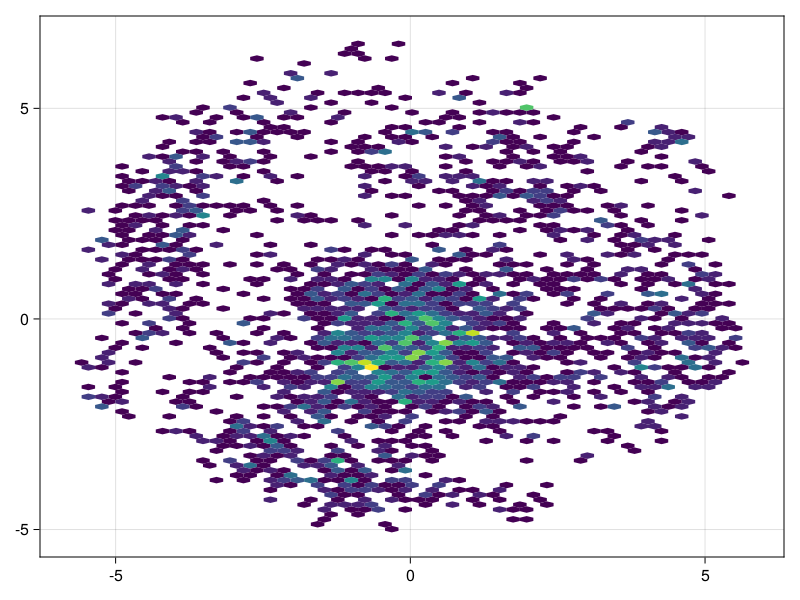

In [9]:
display(md"""
# Visualizing prime gaps

The difference between contiguous prime numbers is called a [Prime gap](https://en.wikipedia.org/wiki/Prime_gap). We use this series of values as a time series example due to its interesting behavior and since it can be computed without downloading more than the necessary packages.

This example shows how to generate the dataset and index it. We will use the `ManifoldLearning` for generating the 2d visualization. This example is based on the example `primegaps-demo.jl` that works with UMAP.

## Generation of the dataset

The time series is represented with windows of size `w`, we also take `log` of gaps to reduce variance in gap values. We create a matrix to avoid redefinition of the knn interface for `ManifoldLearning`.
""")

function create_database_primes_diff(n, w)
	T = log2.(diff(primes(n)))
	M = Matrix{Float32}(undef, w, length(T) - w)
	@info size(M)
	for i in 1:size(M, 2)
		M[:, i] .= view(T, i:(i+w-1))
	end

	M
end


let
    P = create_database_primes_diff(3 * 10^4, 5)
    # or LLE
    primesgap = fit(Isomap, P; k=8, maxoutdim=2, nntype=ApproxEuclidean)
    
	p = predict(primesgap)
	x, y = p[1, :], p[2, :]
	hexbin(x, y; bins=100)
end